In [14]:
#Import statements
import os 
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import PIL.Image
from pathlib import Path
from matplotlib.image import imread
import plotly.express as px 
from keras.models import Model
import keras
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import cv2
import itertools
import random
from collections import Counter
from glob import iglob

In [15]:
#Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing the dataset from drive
data_dir = '/content/drive/MyDrive/dataset'

In [ ]:
#Printing the classes
classes = os.listdir(data_dir)
print(classes)

['rain', 'glaze', 'rime', 'snow', 'fogsmog', 'frost', 'lightning', 'rainbow', 'hail', 'sandstorm', 'dew']


In [ ]:
print('Number of classes:',len(classes))

Number of classes: 11


In [ ]:
#Setting the parameters
batch_size = 32
img_height = 300
img_width = 300

In [ ]:
#Defining the train data with the parameters
train = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  color_mode="rgb", 
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Defining the validation data with the parameters
val = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 5147 files for training.
Found 6862 files belonging to 11 classes.
Using 1715 files for validation.


In [ ]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


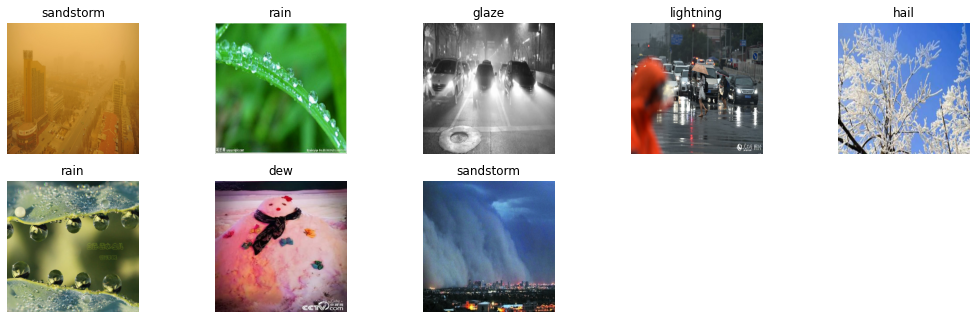

In [ ]:
#Plotting the training dataset images
plt.figure(figsize=(18, 14))
for images, labels in train.take(1):
  for i in range(8):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [24]:
module_selection = ("inception_v3", 299, 2048)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


In [25]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [26]:
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [33]:
#print("Building model with", MODULE_HANDLE)
num_classes=11
#creating a sequential model
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  # Convolutional 2D
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  #Max Pooling
  tf.keras.layers.MaxPooling2D(),
  # Convolutional 2D
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #Max Pooling
  tf.keras.layers.MaxPooling2D(),
  # Convolutional 2D
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #Max Pooling
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.build((None,)+IMAGE_SIZE+(3,))

In [34]:
LEARNING_RATE = 0.001 #@param {type:"number"}
model.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 148, 148, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 71, 71, 32)       

In [ ]:
#training the model
history=model.fit(train, validation_data=val,epochs=3)

Epoch 1/3
161/161 [==============================] - 524s 3s/step - loss: 1.5556 - accuracy: 0.4807 - val_loss: 1.3407 - val_accuracy: 0.5598
Epoch 2/3
161/161 [==============================] - 518s 3s/step - loss: 1.0229 - accuracy: 0.6672 - val_loss: 1.0854 - val_accuracy: 0.6397
Epoch 3/3
161/161 [==============================] - 519s 3s/step - loss: 0.7870 - accuracy: 0.7439 - val_loss: 0.9888 - val_accuracy: 0.7108


In [ ]:
#saving the model
model.save('./model' + '.h5')

Text(0.5, 0, 'Training Steps')

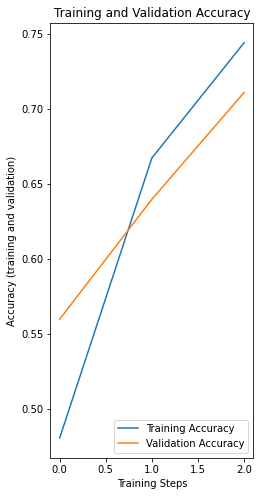

In [ ]:
#plotting the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

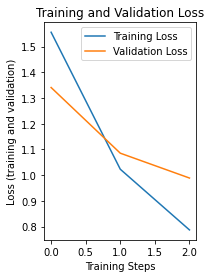

In [ ]:
#plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
#function to predict the image
def predict(image):
    probabilities = model.predict(np.asarray([image]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

In [ ]:
#function to load the image
def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, val, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img

ACTUAL IMAGE: Type: rain
PREDICTION: Type: rain, confidence: 12.862794
ACTUAL IMAGE: Type: dew
PREDICTION: Type: lightning, confidence: 6.640868
ACTUAL IMAGE: Type: rainbow
PREDICTION: Type: lightning, confidence: 7.538097
ACTUAL IMAGE: Type: dew
PREDICTION: Type: rain, confidence: 5.189725
ACTUAL IMAGE: Type: lightning
PREDICTION: Type: snow, confidence: 3.616833
ACTUAL IMAGE: Type: hail
PREDICTION: Type: frost, confidence: 8.355309
ACTUAL IMAGE: Type: sandstorm
PREDICTION: Type: sandstorm, confidence: 9.846929
ACTUAL IMAGE: Type: sandstorm
PREDICTION: Type: sandstorm, confidence: 7.957031
ACTUAL IMAGE: Type: hail
PREDICTION: Type: hail, confidence: 5.881232


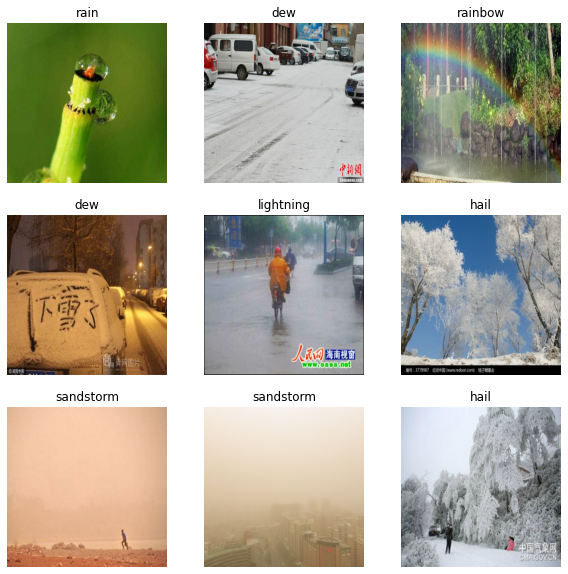

In [ ]:
#Printing the validation images(unseen images)
plt.figure(figsize=(10, 10))
for images, labels in val.take(1):
  for i in range(9):
    print("ACTUAL IMAGE: Type: %s" % (classes[labels[i]]))
    ax = plt.subplot(3, 3, i + 1)
    prediction=predict(images[i])
    print("PREDICTION: Type: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.title(classes[labels[i]])
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")


**Integrating the model to the UI using gradio**

In [2]:
pip install gradio

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 253 kB 53.3 MB/s 
     |████████████████████████████████| 84 kB 3.2 MB/s 
     |████████████████████████████████| 212 kB 55.6 MB/s 
     |████████████████████████████████| 2.0 MB 51.1 MB/s 
     |████████████████████████████████| 1.1 MB 21.8 MB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 94 kB 2.7 MB/s 
     |████████████████████████████████| 271 kB 73.2 MB/s 
     |████████████████████████████████| 144 kB 58.4 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 
     |████████████████████████████████| 10.9 MB 41.6 MB/s 
     |████████████████████████████████| 79 kB 7.5 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 856 kB 57.3 MB/s 
     |████████████████████████████████| 4.0 MB 34.0 MB/s 
     |██████████████████████

In [9]:
#importing the libraries required

import requests
import gradio as gr
from keras.models import load_model

In [16]:
#loading the model

model1=load_model('model.h5')

In [17]:
#providing the labels of our dataset

labels = ['rain', 'glaze', 'rime', 'snow', 'fogsmog', 'frost', 'lightning', 'rainbow', 'hail', 'sandstorm', 'dew']
print(labels)

['rain', 'glaze', 'rime', 'snow', 'fogsmog', 'frost', 'lightning', 'rainbow', 'hail', 'sandstorm', 'dew']


In [18]:
#function to classify the image
from gc import set_debug
def classify_image(inp):
  inp = inp.reshape((-1, 300, 300, 3))
  prediction = model1.predict(inp).flatten()
  confidences = {labels[i]: float(prediction[i]) for i in range(10)}
  print(confidences)
  return confidences

In [20]:
#gradio interface to check/test the classification of the images
gr.Interface(fn=classify_image, 
             inputs=gr.inputs.Image(shape=(300, 300)),
             outputs=gr.outputs.Label(num_top_classes=3)).launch(debug=False)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://42777.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f60b5ab3390>,
 'http://127.0.0.1:7861/',
 'https://42777.gradio.app')